**Курсовая работа по курсу "Параллельные и распределенные вычисления"**

#Запуск через MPI

In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=5997293 sha256=9cf5ed858d40beaf20eb8cd7e9b6ff6ca5e8b89081270c403f6fc71219719ef0
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


In [ ]:
!mpirun -np 4 --oversubscribe --allow-run-as-root python '/content/m.py'

Датасет загружен и готов к отправке! Выполняется рассылка частей датасета, используемых для обучения моделей на узлах.
Узел #2 проходит обучение. Epoch 1: train_loss: 1.8081, val_loss: 1.7974, val_acc: 0.0000.
Узел #3 проходит обучение. Epoch 1: train_loss: 1.8008, val_loss: 1.6940, val_acc: 0.5000.
Узел #1 проходит обучение. Epoch 1: train_loss: 1.7556, val_loss: 1.8168, val_acc: 0.0000.
Узлы обучили модели: ['Узел №1 обучен', 'Узел №2 обучен', 'Узел №3 обучен']
Выполняется рассылка части датасета, по которой будут получены предсказания на узлах.
Предсказание узла #1: paper.
Предсказание узла #3: paper.
Предсказание узла #2: plastic.
Предсказания получены! Проводится ансамблевое голосование...
Результат голосования:  paper


#Пояснения к выбранной модели

Для обучения узлов исппользуется модель: [ResNet50](https://www.kaggle.com/code/aadhavvignesh/pytorch-garbage-classification-95-accuracy).

Обучение происходит на датасете: [Garbage Classification](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification).

In [ ]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

Импортируем датасет картинок [Garbage Classification](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification), содержащий 6 классов:

In [ ]:
data_dir  = '/content/drive/MyDrive/Colab Files/GarbageClassification2'
classes = os.listdir(data_dir)
print(classes)

['trash', 'plastic', 'paper', 'metal', 'glass', 'cardboard']


Выполняем преоброзование из изобажений в тензоры

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
dataset = ImageFolder(data_dir, transform = transformations)

Пример данных датасета [Garbage Classification](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification):

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: glass (Class No: 1)


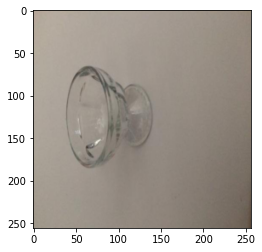

In [ ]:
img, label = dataset[12]
show_sample(img, label)

Разбиваем датасет [Garbage Classification](https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification) на обучающую, валидирующую и тестовую выборки (используется малая часть датасета для наиболее быстрого обучения модели):

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [54, 5, 1])
len(train_ds), len(val_ds), len(test_ds)

(54, 5, 1)

Подготавливаем датасет для обучения модели при помощи Pytorch:

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

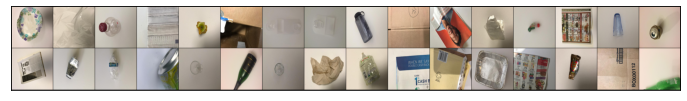

In [ ]:
show_batch(train_dl)

Подготовка модели ResNet50:

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
evaluate(ResNet(), val_dl)

{'val_loss': 1.8249202966690063, 'val_acc': 0.0}

Обучение модели

In [ ]:
num_epochs = 1
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.7848, val_loss: 1.6976, val_acc: 1.0000


Тестирование модели

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: glass , Predicted: glass


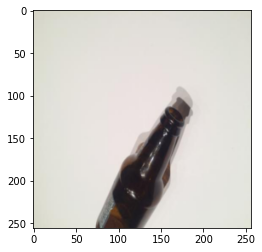

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

#Файл main.py

In [ ]:
from mpi4py import MPI
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
import numpy as np
import warnings
warnings.filterwarnings(action="ignore", lineno=0) 

comm = MPI.COMM_WORLD
rank = comm.rank
size = comm.size
data_train = None 
data_val = None
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

if rank == 0:
  data_dir = '/content/sample_data/GarbageClassification2'
  transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
  dataset = ImageFolder(data_dir, transform = transformations)
  train_ds1, train_ds2, train_ds3, val_ds1, val_ds2, val_ds3, test_ds = random_split(dataset, [17, 17, 17, 2, 2, 2, 3])
  data_train = [0, train_ds1, train_ds2, train_ds3]
  data_val = [0, val_ds1, val_ds2, val_ds3]
  print("Датасет загружен и готов к отправке! Выполняется рассылка частей датасета, используемых для обучения моделей на узлах.")

train_ds = comm.scatter(data_train, root=0)
val_ds = comm.scatter(data_val, root=0)

data = None
if rank != 0:
  batch_size = 32
  train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
  val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)

  def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  class ImageClassificationBase(nn.Module):
      def training_step(self, batch):
          images, labels = batch 
          out = self(images)                  # Generate predictions
          loss = F.cross_entropy(out, labels) # Calculate loss
          return loss
      
      def validation_step(self, batch):
          images, labels = batch 
          out = self(images)                    # Generate predictions
          loss = F.cross_entropy(out, labels)   # Calculate loss
          acc = accuracy(out, labels)           # Calculate accuracy
          return {'val_loss': loss.detach(), 'val_acc': acc}
          
      def validation_epoch_end(self, outputs):
          batch_losses = [x['val_loss'] for x in outputs]
          epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
          batch_accs = [x['val_acc'] for x in outputs]
          epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
          return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
      
      def epoch_end(self, epoch, result):
          print("Узел #{} проходит обучение. Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}.".format(
              rank, epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))
          
  class ResNet(ImageClassificationBase):
      def __init__(self):
          super().__init__()
          # Use a pretrained model
          self.network = models.resnet50(pretrained=True)
          # Replace last layer
          num_ftrs = self.network.fc.in_features
          self.network.fc = nn.Linear(num_ftrs, len(classes))
      
      def forward(self, xb):
          return torch.sigmoid(self.network(xb))

  model = ResNet()

  @torch.no_grad()
  def evaluate(model, val_loader):
      model.eval()
      outputs = [model.validation_step(batch) for batch in val_loader]
      return model.validation_epoch_end(outputs)

  def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
      history = []
      optimizer = opt_func(model.parameters(), lr)
      for epoch in range(epochs):
          # Training Phase 
          model.train()
          train_losses = []
          for batch in train_loader:
              loss = model.training_step(batch)
              train_losses.append(loss)
              loss.backward()
              optimizer.step()
              optimizer.zero_grad()
          # Validation phase
          result = evaluate(model, val_loader)
          result['train_loss'] = torch.stack(train_losses).mean().item()
          model.epoch_end(epoch, result)
          history.append(result)
      return history

  evaluate(model, val_dl)

  num_epochs = 1
  opt_func = torch.optim.Adam
  lr = 5.5e-5

  history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  data = "Узел №" + str(rank) + " обучен"

data = comm.gather(data, root=0)

if rank == 0:
  print("Узлы обучили модели:", data[1:])
  print("Выполняется рассылка части датасета, по которой будут получены предсказания на узлах.")
  data = test_ds[0]

data = comm.bcast(data)

if rank != 0:
  def predict_image(img, model):
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    prob, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

  img, label = data
  data = predict_image(img, model)
  print("Предсказание узла #{}: {}.".format(rank, data))

data = comm.gather(data, root=0)

if rank == 0:
  print ("Предсказания получены! Проводится ансамблевое голосование...")
  tmp = dict()
  for i in data[1:]:
    if i in tmp:
      tmp[i] += 1
    else:
      tmp[i] = 1

  max_val = max(tmp.values())
  final_dict = {k:v for k, v in tmp.items() if v == max_val}
  final = list(final_dict.keys())
  r = np.random.randint(0, len(final))
  print("Результат голосования: ", final[r])